# CNN for Digit Classification using MNIST dataset

This tutoral will show you:
- How to load a dataset in TensorFlow and batch iterate through the data
- Define the computation graph of a convolutional neural net and train it
- Save checkpoints during training
- Visualize filters and feature maps in TensorBoard

In [1]:
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

### MNIST Dataset

MNIST is a simple computer vision dataset. 
- It consists of images of handwritten digits from 0-9, and their image labels;
- Each image is 28px * 28px;
- The input image is flattened into a vector of 28x28 = 784 numbers, so MNIST images is a tensor (an n-dimensional array) with a shape of [55000, 784];
- MNIST labels is a [55000, 1] array of numbers.

<img src="images/mnist-train-xs.png" style="width: 500px;"/>

Here, we provide you a ``DataLoader`` class to load dataset into memory. 
Two methods are provided to access training and testing data.
- next_batch: return next batch of training data
- load_test: return all testing data

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Label: 7


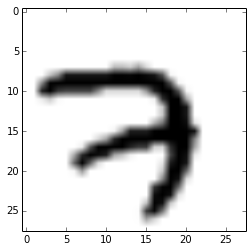

In [2]:
data_dir = 'MNIST_data/'
h = 28  # MNIST image size: 28*28px
w = 28
c = 1   # MNIST data has only one channel, they are grey scale images

from data_loader import DataLoader

# Construct dataloader to load MNIST dataset
loader = DataLoader(data_dir, w, h, c)

# Plot one image and label
plt.imshow(loader.dataset.train.images[0].reshape(h, w)).set_cmap('Greys')
print("Label: %d" % loader.dataset.train.labels[0])

### Set up Compuation Graph

In TensorFlow, a computation graph defines the architecture of neural network. All needed functions to define layers and losses are in ``tf.nn`` module: https://www.tensorflow.org/api_docs/python/tf/nn

The following cell gives you a graph of basic CNN. The network repeats "Convoluation + Non-linearity + Pooling" twice. We provide the weights and biases for each layer but didn't fill in the details of those layers. Here are the APIs you need:
- [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d): use stride 1, filter size is defined in ``weights``
- [tf.nn.relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu)
- [tf.nn.max_pool](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool): use 2x2 filter and stride 2

To better understand what the model learns, we created utility functions in ``visualizer.py`` to visualize convolution kernels and layer outputs. When defining computation graph, we need to add the interesting variables to image summary so that we can see them in TensorBoard.

In [3]:
def init_weights(shape):
    """ Random initialize weight variable """
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def init_bias(shape):
    """ Initialize bias variable to zero """
    return tf.Variable(tf.zeros(shape))

def cnn(x, keep_dropout):
    """ Define the CNN computation graph """

    weights = {
        'wc1': init_weights([5, 5, 1, 32]),   # 5x5x1 conv, 32 outputs
        'wc2': init_weights([5, 5, 32, 64]),  # 5x5x32 conv, 64 outputs
        'wf3': init_weights([7*7*64, 1024]),  # Fully Connected 7*7*64 inputs, 1024 outputs
        'wo': init_weights([1024, 10]),       # Fully Connected 1024 inputs, 10 outputs 
    }
    biases = {
        'bc1': init_bias(32),
        'bc2': init_bias(64),
        'bf3': init_bias(1024),
        'bo': init_bias(10),
    }
    
    from visualizer import visualize_filter, visualize_feature

    # Convolution + ReLU + Pooling
    conv1 = tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, biases['bc1']))
    pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    tf.summary.image('kernel1', visualize_filter(weights['wc1']), max_outputs=1)
    tf.summary.image('relu1',visualize_feature(relu1), max_outputs=1)
    tf.summary.image('pool1',visualize_feature(pool1), max_outputs=1)

    # Convolution + ReLU + Pooling
    conv2 = tf.nn.conv2d(pool1, weights['wc2'], strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, biases['bc2']))
    pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    tf.summary.image('kernel2', visualize_filter(weights['wc2']), max_outputs=1)
    tf.summary.image('relu2',visualize_feature(relu2), max_outputs=1)
    tf.summary.image('pool2',visualize_feature(pool2), max_outputs=1)

    # Fully Connected + ReLU + Dropout
    fc3 = tf.reshape(pool2, [-1, weights['wf3'].get_shape().as_list()[0]])
    fc3 = tf.add(tf.matmul(fc3, weights['wf3']), biases['bf3'])
    fc3 = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3, keep_dropout)

    # Output Fully Connected
    out = tf.add(tf.matmul(fc3, weights['wo']), biases['bo'])
    
    return out

### Prepare for Training

In [4]:
# Parameters for training
learning_rate = 0.001
training_iters = 500
batch_size = 100
step_display = 10
step_save = 500
path_save = 'models/mnist_cnn'

# Network Parameters
dropout = 0.5  # Dropout, probability to keep units

Before we can train the model, we also need to decide which loss and optimizer we want to use for back propagation. Here are some optimizer you can try:
- [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)
- [tf.train.AdadeltaOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdadeltaOptimizer)
- [tf.train.AdagradOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer)
- [tf.train.AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)

In [5]:
# Define input of computation graph
x = tf.placeholder(tf.float32, [None, h, w, c])
y = tf.placeholder(tf.int64, None)
keep_dropout = tf.placeholder(tf.float32)

# Construct model
logits = cnn(x, keep_dropout)

# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))
train_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Set up model evaluation metrics
correct_pred = tf.equal(tf.argmax(logits, 1), y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [6]:
# Initialize session
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Define saver to write out model checkpoint
saver = tf.train.Saver()

# Configure summary writer to write out logs
LOG_DIR = "logs"
summary_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
merged = tf.summary.merge_all()

### Training

Now, we're ready to run training on the data batches!

In [7]:
step = 1
while step < training_iters:
    # Load a batch of data
    images_batch, labels_batch = loader.next_batch(batch_size)
        
    # Run optimization (i.e. back propagation)
    summary, _ = sess.run([merged, train_optimizer],
                          feed_dict={x: images_batch, y: labels_batch, keep_dropout: dropout})
    
    # Display loss and accuracy every ``step_display`` iterations
    if step % step_display == 0:
        # Calculate batch loss and accuracy while training
        l, acc = sess.run([loss, accuracy],
                          feed_dict={x: images_batch, y: labels_batch, keep_dropout: 1.}) 
        print("Iter %d, Minibatch Loss = %.6f, Training Accuracy = %.4f" % (step, l, acc))
        
    step += 1
        
    # Save model
    if step % step_save == 0:
        saver.save(sess, path_save, global_step=step)
        print "Model saved at Iter %d !" %(step)

    # Add summary to writer at each iteration
    summary_writer.add_summary(summary, step)
        
print("Finished training!")
summary_writer.close()

Iter 10, Minibatch Loss = 1.862742, Training Accuracy = 0.5200
Iter 20, Minibatch Loss = 0.778925, Training Accuracy = 0.6600
Iter 30, Minibatch Loss = 0.782985, Training Accuracy = 0.6900
Iter 40, Minibatch Loss = 0.504283, Training Accuracy = 0.8500
Iter 50, Minibatch Loss = 0.294770, Training Accuracy = 0.8700
Iter 60, Minibatch Loss = 0.381130, Training Accuracy = 0.9000
Iter 70, Minibatch Loss = 0.259445, Training Accuracy = 0.9500
Iter 80, Minibatch Loss = 0.366366, Training Accuracy = 0.8800
Iter 90, Minibatch Loss = 0.402122, Training Accuracy = 0.9000
Iter 100, Minibatch Loss = 0.203817, Training Accuracy = 0.9100
Iter 110, Minibatch Loss = 0.290456, Training Accuracy = 0.9400
Iter 120, Minibatch Loss = 0.153579, Training Accuracy = 0.9400
Iter 130, Minibatch Loss = 0.186846, Training Accuracy = 0.9200
Iter 140, Minibatch Loss = 0.057914, Training Accuracy = 0.9800
Iter 150, Minibatch Loss = 0.084986, Training Accuracy = 0.9500
Iter 160, Minibatch Loss = 0.180626, Training Acc

### Testing

After training, we can run the model on a test set to understand its performance.

In [8]:
# Calculate accuracy for test images
images_test, labels_test = loader.load_test()
test_accuracy = sess.run(accuracy, feed_dict={x: images_test,
                                              y: labels_test,
                                              keep_dropout: 1.})
print("Testing Accuracy: %f" % test_accuracy)

Testing Accuracy: 0.979900


### Check Visualization in TensorBoard

Since we write out summary to logs directory, we can use TensorFlow to see the stats we add to the summary.

To launch TensorBoard, you should type this in your terminal or command prompt:

    tensorboard --logdir=logs/
    
It will reads the files in logs/ directory.

Then, in your favorite browser, go to ``localhost:6006`` to and click on "Images" tab to see visualization of filters.

### Done. Congrats!

You have finished this tutorial. But, this is just a start, feel free to try different things on this simple CNN. For example,
- add more layers
- try different hyperparameters
- add more stats to summary
- etc.